# Self-Driving Car Engineer Nanodegree

## Project #2: **Advanced Lane Finding**


### Notebook Configuration

In [9]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

## Import Packages

In [10]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import math
import pathlib as pl
from moviepy.editor import VideoFileClip
from IPython.display import HTML

%matplotlib inline

## Camera Calibration

In [11]:
chessboard_nx = 9
chessboard_ny = 6

def calibrate_camera(shape):

    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((chessboard_ny*chessboard_nx,3), np.float32)
    objp[:,:2] = np.mgrid[0:chessboard_nx,0:chessboard_ny].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Make a list of calibration images
    calibration_dir = "camera_cal"

    # plt.figure()
    # fig, axs = plt.subplots(2, 3, figsize=(10,5), tight_layout=True)
    # ax_iter = iter(axs.flatten())

    # Step through the list and search for chessboard corners
    for file in sorted(pl.Path(calibration_dir).glob("cal*.jpg")):
        img = cv2.imread(str(file))
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (chessboard_nx,chessboard_ny),None)

        if ret == False:
            continue

        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        # img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        #
        # ax = next(ax_iter, None)
        # if ax != None:
        #     ax.imshow(img)

    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, shape, None, None)
    return (mtx, dist)


def undistort_image(img, cal):
    return cv2.undistort(img, cal[0], cal[1], None, cal[0])

## Verify Camera Calibration

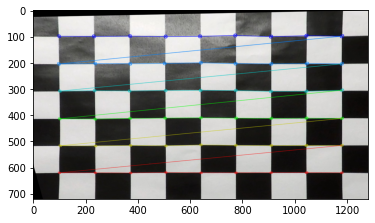

In [12]:
def undistort_warp_chessboard(img, cal):
    w, h = img.shape[1::-1]

    img_undist = undistort_image(img, cal)
    img_undist = cv2.cvtColor(img_undist, cv2.COLOR_BGR2RGB)

    ret, corners = cv2.findChessboardCorners(img_undist, (chessboard_nx,chessboard_ny), None)
    if ret:
        cv2.drawChessboardCorners(img_undist, (chessboard_nx,chessboard_ny), corners, True)
        src = np.array([corners[0], corners[chessboard_nx-1], corners[-1], corners[-chessboard_nx]], dtype=np.float32);
        dst = np.array([[100,100], [w-100,100], [w-100,h-100], [100,h-100]], dtype=np.float32);
        M = cv2.getPerspectiveTransform(src, dst)
        img_undist = cv2.warpPerspective(img_undist, M, (w, h), flags=cv2.INTER_CUBIC)

    return img_undist


# test camera calibration
img = cv2.imread('camera_cal/calibration3.jpg')
w, h = img.shape[1::-1]
cal = calibrate_camera((w, h))
img = undistort_warp_chessboard(img, cal)
plt.figure()
plt.imshow(img)


## Gradient and Color Thresholds

In [14]:
def thresholds(img, s_thresh=(170, 255), h_thresh=(20, 25),
               ksize=5, sx_thresh=(20, 100), mag_thresh=(0, 255), dir_thresh=((0, np.pi/2))):
    #img = np.copy(img)

    # convert to HLS color space
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    h_channel = hls[:,:,0]
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]

    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0, ksize=ksize) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobelx = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

    # Sobel y
    sobely = cv2.Sobel(l_channel, cv2.CV_64F, 0, 1, ksize=ksize)
    abs_sobely = np.absolute(sobely)
    scaled_sobely = np.uint8(255*abs_sobely/np.max(abs_sobely))

    abs_sobelxy = np.sqrt(np.square(sobelx)+np.square(sobely))
    scaled_sobelxy = np.uint8(255*abs_sobelxy/np.max(abs_sobelxy))

    # use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient
    dir_sobel = np.arctan2(abs_sobely, abs_sobelx)

    # threshold gradient magnitude
    mag_binary = np.zeros_like(scaled_sobelxy)
    mag_binary [(scaled_sobelxy >= mag_thresh[0]) & (scaled_sobelxy <= mag_thresh[1])] = 1

    # threshold direction
    dir_binary = np.zeros_like(dir_sobel)
    dir_binary [(dir_sobel >= dir_thresh[0]) & (dir_sobel <= dir_thresh[1])] = 1

    # threshold x gradient
    sobelx_binary = np.zeros_like(scaled_sobelx)
    sobelx_binary[(scaled_sobelx >= sx_thresh[0]) & (scaled_sobelx <= sx_thresh[1])] = 1

    # threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1

    h_binary = np.zeros_like(h_channel)
    h_binary[(h_channel >= h_thresh[0]) & (h_channel <= h_thresh[1])] = 1

    combined_binary = np.zeros_like(sobelx_binary)
    combined_binary[(s_binary == 1) | (sobelx_binary == 1) | (h_binary == 1)] = 1
    return combined_binary

    #color_binary = np.dstack((sxbinary, h_binary, s_binary)) * 255
    #return color_binary


## Perspective Transform

In [ ]:
def warper(img):

    img_size = img.shape[1::-1]

    # define a trapezoid a source for the perspective transform
    src = np.float32([
        [(img_size[0] / 2) - 55, img_size[1] / 2 + 100],
        [((img_size[0] / 6) - 10), img_size[1]],
        [(img_size[0] * 5 / 6) + 60, img_size[1]],
        [(img_size[0] / 2 + 55), img_size[1] / 2 + 100]
    ])

    # destination geometry is a rectangle
    dst = np.float32([
        [(img_size[0] / 4), 0],
        [(img_size[0] / 4), img_size[1]],
        [(img_size[0] * 3 / 4), img_size[1]],
        [(img_size[0] * 3 / 4), 0]
    ])

    # compute and apply perpective transform
    global M
    if M == None:
        M = cv2.getPerspectiveTransform(src, dst)

    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_NEAREST)
    return warped


## Helper Functions

In [15]:
def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        # ind the four below boundaries of the window
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin

        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2)
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2)


        ### Identify the nonzero pixels in x and y within the window ###
        good_left_inds = ((win_xleft_low <= nonzerox) & (nonzerox < win_xleft_high) & (win_y_low <= nonzeroy) & (nonzeroy < win_y_high)).nonzero()[0]
        good_right_inds = ((win_xright_low <= nonzerox) & (nonzerox < win_xright_high) & (win_y_low <= nonzeroy) & (nonzeroy < win_y_high)).nonzero()[0]

        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)

        ### If you found > minpix pixels, recenter next window ###
        ### (`right` or `leftx_current`) on their mean position ###
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img


def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    ### Fit a second order polynomial to each using `np.polyfit` ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')

    return out_img


# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False
        # x values of the last n fits of the line
        self.recent_xfitted = []
        #average x values of the fitted line over the last n iterations
        self.bestx = None
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]
        #radius of curvature of the line in some units
        self.radius_of_curvature = None
        #distance in meters of vehicle center from the line
        self.line_base_pos = None
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float')
        #x values for detected line pixels
        self.allx = None
        #y values for detected line pixels
        self.ally = None





def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)

## Build a Lane Finding Pipeline



In [16]:
def pipeline(img):
    """
    Process a single image through the complete pipeline.
    """
    
    # image dimensions
    h = img.shape[0]
    w = img.shape[1]
    
    # relative y-position of the (hard-coded) line horizon
    horizon = 0.62;
    
    # the region of interest as a trapezoid
    region = np.array( [ \
                        [0.05*w, 1.0*h], \
                        [0.45*w, horizon*h], \
                        [0.55*w, horizon*h], \
                        [0.95*w, 1.0*h] \
                       ], dtype=np.int32 )
    
    #plt.figure()
    #plt.imshow(img)
    
    # select color (filtering dark parts of the image but allowing darker yet yellowish areas)
    proc_img = color_select(img, (130, 130, 40), (255, 255, 255))
    
    #plt.figure()
    #plt.imshow(proc_img, cmap='gray')
    
    # cut region to the configure trapezoid
    proc_img = region_of_interest(proc_img, [region])
    
    #plt.figure()
    #plt.imshow(proc_img, cmap='gray')
    
    # apply Gaussian blur
    proc_img = gaussian_blur(proc_img, 5)
    
    #plt.figure()
    #plt.imshow(proc_img, cmap='gray')
    
    # apply Canny Edge
    proc_img = canny(proc_img, 50, 130)
    
    #plt.figure()
    #plt.imshow(proc_img, cmap='gray')
    
    # detect line segments with Hough Transform (allowing relatively short lines as well)
    # and filter/extrapolate
    proc_img = hough_lines(proc_img, 2, np.pi/180, 30, 20, 5, horizon)
    
    #plt.figure()
    #plt.imshow(proc_img, cmap='gray')
    
    # overlay the extrapolated lane lines onto the original image
    proc_img = weighted_img(proc_img, img, 0.7, 1.0)
    
    return proc_img

## Execute on Images
Executing the pipeline on all images in 'test_images'.

In [17]:
# apply the processing pipe line to all images in the input directory

input_dir = 'test_images'
output_dir = 'output_images'

for file in sorted(pal.Path(input_dir).iterdir()):

    # read and process
    image = mpimg.imread(str(file))
    image = pipeline(image)
    
    # plot in notebook
    plt.figure()
    plt.title("{} {}".format(file.name, image.shape))
    plt.imshow(image)
    
    # write to file
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    cv2.imwrite(output_dir + '/' + file.name, image)

NameError: name 'pal' is not defined

## Execute on Videos
Executing the pipeline on all videos in 'test_videos', including **the challenge**!

In [ ]:
# apply the processing pipe line to all videos in the input directory

input_dir = 'test_videos'
output_dir = 'test_videos_output'

for file in sorted(pal.Path(input_dir).iterdir()):
    
    print('Parsing video "', file, '" with dimensions ', sep='')
    clip = VideoFileClip(str(file))
    #clip = VideoFileClip(str(file)).subclip(0,5)
    
    file_output = output_dir + '/' + file.name
    clip_output = clip.fl_image(pipeline)
    
    %time clip_output.write_videofile(file_output, audio=False)    

    display(HTML("""
<div>{1}</div>
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(file_output, file_output)))
    print()

We are done!